In [21]:
import datetime
import time
import unittest
import pandas as pd
import pytz
import matplotlib.pyplot as plt
import mplfinance as mpf

In [22]:
from tigeropen.common.consts import BarPeriod
from tigeropen.quote.quote_client import QuoteClient
from tigeropen.tiger_open_config import TigerOpenClientConfig

In [23]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', 1000)

In [24]:
def get_client_config():
    """
    https://quant.itigerup.com/#developer 开发者信息获取
    """
    # 港股牌照需用 props_path 参数指定token路径，如 '/Users/xxx/xxx/', 如不指定则取当前路径
    client_config = TigerOpenClientConfig(props_path='tiger_openapi_config.properties')
    return client_config

In [25]:
# 调用上方定义的函数生成用户配置ClientConfig对象
client_config = get_client_config()

# 随后传入配置参数对象来初始化QuoteClient
quote_client = QuoteClient(client_config)

SYMBOL = "symbol"
TIME = "time"
CLOSE = "close"
DATE = "date"

# 需要请求的k线bar的总个数.  total number of requested bars.
BARS_TOTAL_NUMBER = 2000

# 每次请求bar的个数，系统限制每个symbol每次最多请求1200个bar.
# number of bars per request, the system limits each symbol to a maximum of 1200 bars per request.
BARS_BATCH_SIZE = 300

# 每次请求symbol的个数，系统限制每次最多请求50个symbol
# number of symbols per request, the system limits each request to a maximum of 50 symbols.
SYMBOLS_BATCH_SIZE = 50

# 每次请求的间隔时间，防止过快的请求频率触发系统限流. 单位：秒
# The interval between each request, to prevent requests too fast to trigger the system rate limit. Time unit: second
REQUEST_INTERVAL = 0.5

In [26]:
def request_bars(symbols, period, end_time, bars_batch_size):
        """
        请求k线. Request history bars.
        :param symbols: like ['AAPL', 'TSLA']
        :param period: k线周期. tigeropen.common.consts.BarPeriod. like BarPeriod.DAY
        :param end_time: end time in timestamp format. like 1645499400000
        :param bars_batch_size: 每个symbol限制请求的bar数量. bars limit size of each symbol
        :return:
        """
        symbols = list(symbols)
        result = pd.DataFrame()
        for i in range(0, len(symbols), SYMBOLS_BATCH_SIZE):
            part = symbols[i:i + SYMBOLS_BATCH_SIZE]
            quote = quote_client.get_bars(part, period=period, end_time=end_time, limit=bars_batch_size)
            #result = result.append(quote)
            result = pd.concat([result, quote])
            # to avoid rate limit
            time.sleep(REQUEST_INTERVAL)
        return result

In [42]:
# HK market
symbols = ['00700', '01024', '03690', '00992', '00762', '00998', '02020', '01109', '00981', '03988', '01398']
timezone = 'Asia/Shanghai'

# US market
# symbols = ['BABA', 'PDD', 'JD', 'NTES', 'NIO', 'XPEV', 'LI']
# timezone = 'US/Eastern'

end = int(datetime.datetime.today().timestamp() * 1000)
history = pd.DataFrame()
for i in range(0, BARS_TOTAL_NUMBER, BARS_BATCH_SIZE):
    if i + BARS_BATCH_SIZE <= BARS_TOTAL_NUMBER:
        limit = BARS_BATCH_SIZE
    else:
        limit = i + BARS_BATCH_SIZE - BARS_TOTAL_NUMBER
    end_time = datetime.datetime.fromtimestamp(end/1000, pytz.timezone(timezone))
    print(f'query {len(symbols)} symobls history, end_time:{end} -- {end_time}, limit:{limit}')
    # 其他周期可修改period参数. 
    part = request_bars(symbols=symbols, period=BarPeriod.MONTH, end_time=end, bars_batch_size=BARS_BATCH_SIZE)
    part[DATE] = pd.to_datetime(part[TIME], unit='ms').dt.tz_localize('UTC').dt.tz_convert(timezone)
    if (len(part[TIME]) == 0): 
        break
    end = min(part[TIME])
    history = pd.concat([history, part])
history.set_index([DATE], inplace=True)
history.sort_index(inplace=True)

# 2006年1月1日
history.drop(history[history[TIME] < 1136044800000].index, inplace=True)

history.drop('time', axis=1, inplace=True)
history.drop('amount', axis=1, inplace=True)
history.drop('next_page_token', axis=1, inplace=True)

print(history)

query 11 symobls history, end_time:1706360172899 -- 2024-01-27 20:56:12.899000+08:00, limit:300
query 11 symobls history, end_time:917798400000 -- 1999-02-01 00:00:00+08:00, limit:300
query 11 symobls history, end_time:760032000000 -- 1994-02-01 00:00:00+08:00, limit:300
                          symbol    open    high     low   close      volume
date                                                                        
2006-01-01 00:00:00+08:00  00981  10.300  13.100  10.100  12.900   166030021
2006-01-01 00:00:00+08:00  01109   1.932   2.704   1.859   2.583  1026334649
2006-01-01 00:00:00+08:00  00700   1.454   1.863   1.454   1.741   507476036
2006-01-01 00:00:00+08:00  00992   1.930   2.022   1.617   1.688  2013205072
2006-01-01 00:00:00+08:00  00762   3.999   4.507   3.999   4.380   483466301
...                          ...     ...     ...     ...     ...         ...
2024-01-01 00:00:00+08:00  00981  20.050  20.050  14.740  15.560   597715215
2024-01-01 00:00:00+08:00  03690  8

In [43]:
ind = history.groupby('date').agg({'open':'sum', 'high':'sum', 'low':'sum', 'close':'sum', 'volume':'sum'}).reset_index()
indexation = pd.DataFrame(ind)
indexation.set_index([DATE], inplace=True)
indexation.sort_index(inplace=True)

print(indexation)

                              open     high      low    close       volume
date                                                                      
2006-01-01 00:00:00+08:00   19.615   24.196   19.029   23.292   4196512079
2006-02-01 00:00:00+08:00   23.460   24.337   20.601   21.842   2699511405
2006-03-01 00:00:00+08:00   21.792   24.293   20.648   22.864   2632147232
2006-04-01 00:00:00+08:00   22.922   24.967   21.442   23.457   2301892439
2006-05-01 00:00:00+08:00   23.630   25.577   20.639   22.643   3309123774
...                            ...      ...      ...      ...          ...
2023-09-01 00:00:00+08:00  694.620  714.596  620.397  646.884  13372903509
2023-10-01 00:00:00+08:00  634.464  680.811  589.197  614.975  13218242329
2023-11-01 00:00:00+08:00  615.705  689.777  573.888  632.340  12248677396
2023-12-01 00:00:00+08:00  630.190  634.050  526.680  578.360  11946134505
2024-01-01 00:00:00+08:00  587.260  594.770  486.250  527.130  13920354952

[217 rows x 5 columns]


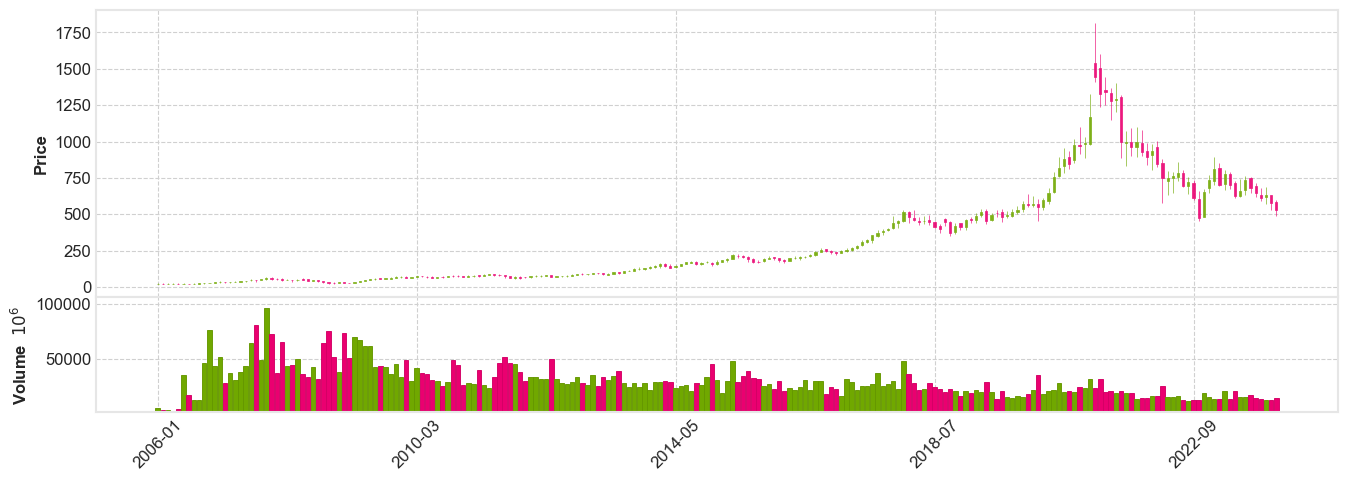

In [44]:
mpf.plot(indexation, type='candle', style='binance', datetime_format='%Y-%m', volume=True, figratio=(30, 10))